##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title License header
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST Model TensorFlow Training, IREE Execution

## Overview

This notebook creates and trains a TensorFlow 2.0 model for recognizing handwritten digits using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), then compiles and executes that trained model using IREE.

## Running Locally

*  Refer to [iree/docs/using_colab.md](https://github.com/google/iree/blob/main/docs/using_colab.md) for general information
*  Ensure that you have a recent version of TensorFlow 2.0 [installed on your system](https://www.tensorflow.org/install)
*  Enable IREE/TF integration by adding to your user.bazelrc: `build --define=iree_tensorflow=true`
*  Start colab by running `python colab/start_colab_kernel.py` (see that file for additional instructions)
*  Note: you may need to restart your runtime in order to re-run certain cells. Some of the APIs are not yet stable enough for repeated invocations

# Setup Steps

In [2]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from pyiree.tf import compiler as ireec
from pyiree import rt as ireert
from timeit import default_timer as timer

tf.compat.v1.enable_eager_execution()

SAVE_PATH = os.path.join(os.environ["HOME"], "saved_models")
os.makedirs(SAVE_PATH, exist_ok=True)

# Print version information for future notebook users to reference.
print("TensorFlow version: ", tf.__version__)
print("Numpy version: ", np.__version__)

TensorFlow version:  2.2.0
Numpy version:  1.19.0


In [3]:
#@title Notebook settings { run: "auto" }

#@markdown -----
#@markdown ### Configuration

backend_choice = "GPU (vulkan-spirv)" #@param [ "GPU (vulkan-spirv)", "CPU (VMLA)" ]

if backend_choice == "GPU (vulkan-spirv)":
  backend_name = "vulkan-spirv"
  driver_name = "vulkan"
else:
  backend_name = "vmla"
  driver_name = "vmla"
    
backend_name = "llvm-ir"
driver_name = "llvm"
tf.print("Using IREE compiler backend '%s' and runtime driver '%s'" % (backend_name, driver_name))

#@markdown -----
#@markdown ### Training Parameters

#@markdown <sup>Batch size used to subdivide the training and evaluation samples</sup>
batch_size = 200  #@param { type: "slider", min: 10, max: 400 }

#@markdown <sup>Epochs for training/eval. Higher values take longer to run but generally produce more accurate models</sup>
num_epochs = 5    #@param { type: "slider", min:  1, max:  20 }

#@markdown -----

Using IREE compiler backend 'llvm-ir' and runtime driver 'llvm'


# Create and Train MNIST Model in TensorFlow

The specific details of the training process here aren't critical to the model compilation and execution through IREE.

Loaded MNIST dataset!
INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:CPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:CPU:0'
Configured data for training and evaluation!
  sample shape: (28, 28, 1)
  training samples: 60000
  test     samples: 10000
  epochs: 5
  steps/epoch: 300
  steps/eval : 50

Sample image from the dataset:


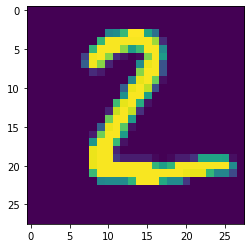


Ground truth labels: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
#@title Load MNIST dataset, setup training and evaluation

NUM_CLASSES = 10  # One per digit [0, 1, 2, ..., 9]
IMG_ROWS, IMG_COLS = 28, 28

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
tf.print("Loaded MNIST dataset!")

x_train = x_train.reshape(x_train.shape[0], IMG_ROWS, IMG_COLS, 1)
x_test = x_test.reshape(x_test.shape[0], IMG_ROWS, IMG_COLS, 1)
input_shape = (IMG_ROWS, IMG_COLS, 1)

# Scale pixel values from [0, 255] integers to [0.0, 1.0] floats.
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

steps_per_epoch = int(x_train.shape[0] / batch_size)
steps_per_eval = int(x_test.shape[0] / batch_size)

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

# Construct batched datasets for training/evaluation.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

# Create a distribution strategy for the dataset (single machine).
strategy = tf.distribute.experimental.CentralStorageStrategy()
train_dist_ds = strategy.experimental_distribute_dataset(train_dataset)
test_dist_ds = strategy.experimental_distribute_dataset(test_dataset)

tf.print("Configured data for training and evaluation!")
tf.print("  sample shape: %s" % str(x_train[0].shape))
tf.print("  training samples: %s" % x_train.shape[0])
tf.print("  test     samples: %s" % x_test.shape[0])
tf.print("  epochs: %s" % num_epochs)
tf.print("  steps/epoch: %s" % steps_per_epoch)
tf.print("  steps/eval : %s" % steps_per_eval)

tf.print("")
tf.print("Sample image from the dataset:")
SAMPLE_EXAMPLE_INDEX = 1
sample_image = x_test[SAMPLE_EXAMPLE_INDEX]
sample_image_batch = np.expand_dims(sample_image, axis=0)
sample_label = y_test[SAMPLE_EXAMPLE_INDEX]
plt.imshow(sample_image.reshape(IMG_ROWS, IMG_COLS))
plt.show()
tf.print("\nGround truth labels: %s" % str(sample_label))

In [5]:
#@title Define MNIST model architecture using tf.keras API

def simple_mnist_model(input_shape):
  """Creates a simple (multi-layer perceptron) MNIST model."""

  model = tf.keras.models.Sequential()
  # Flatten to a 1d array (e.g. 28x28 -> 784)
  model.add(tf.keras.layers.Flatten(input_shape=input_shape))
  # Fully-connected neural layer with 128 neurons, RELU activation
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  # Fully-connected neural layer returning probability scores for each class
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  return model

In [6]:
#@title Train the Keras model

with strategy.scope():
  model = simple_mnist_model(input_shape)
  tf.print("Constructed Keras MNIST model, training...")

  optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
  training_loss = tf.keras.metrics.Mean("training_loss", dtype=tf.float32)
  training_accuracy = tf.keras.metrics.CategoricalAccuracy(
      "training_accuracy", dtype=tf.float32)
  test_loss = tf.keras.metrics.Mean("test_loss", dtype=tf.float32)
  test_accuracy = tf.keras.metrics.CategoricalAccuracy(
      "test_accuracy", dtype=tf.float32)

  @tf.function
  def train_step(iterator):
    """Training StepFn."""

    def step_fn(inputs):
      """Per-Replica StepFn."""
      images, labels = inputs
      with tf.GradientTape() as tape:
        logits = model(images, training=True)
        loss = tf.keras.losses.categorical_crossentropy(labels, logits)
        loss = tf.reduce_mean(loss) / strategy.num_replicas_in_sync
      grads = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      training_loss.update_state(loss)
      training_accuracy.update_state(labels, logits)

    strategy.run(step_fn, args=(next(iterator),))

  @tf.function
  def test_step(iterator):
    """Evaluation StepFn."""

    def step_fn(inputs):
      images, labels = inputs
      logits = model(images, training=False)
      loss = tf.keras.losses.categorical_crossentropy(labels, logits)
      loss = tf.reduce_mean(loss) / strategy.num_replicas_in_sync
      test_loss.update_state(loss)
      test_accuracy.update_state(labels, logits)

    strategy.run(step_fn, args=(next(iterator),))

  for epoch in range(0, num_epochs):
    tf.print("Running epoch #%s" % (epoch + 1))

    train_iterator = iter(train_dist_ds)
    for step in range(steps_per_epoch):
      train_step(train_iterator)
    tf.print("  Training loss: %f, accuracy: %f" % (training_loss.result(), training_accuracy.result() * 100))
    training_loss.reset_states()
    training_accuracy.reset_states()

    test_iterator = iter(test_dist_ds)
    for step in range(steps_per_eval):
      test_step(test_iterator)
    tf.print("  Test loss    : %f, accuracy: %f" % (test_loss.result(), test_accuracy.result() * 100))
    test_loss.reset_states()
    test_accuracy.reset_states()

  tf.print("Completed training!")
  tf.print("")

  # Run a single prediction on the trained model
  tf_prediction = model(sample_image_batch, training=False)
  tf.print("Sample prediction:")
  tf.print(tf_prediction[0] * 100.0, summarize=100)
  tf.print("")

Constructed Keras MNIST model, training...
Running epoch #1
  Training loss: 0.724615, accuracy: 81.996666
  Test loss    : 0.385540, accuracy: 89.580002
Running epoch #2
  Training loss: 0.359276, accuracy: 90.001663
  Test loss    : 0.312792, accuracy: 91.220001
Running epoch #3
  Training loss: 0.306788, accuracy: 91.379997
  Test loss    : 0.279131, accuracy: 92.139999
Running epoch #4
  Training loss: 0.276152, accuracy: 92.221664
  Test loss    : 0.256219, accuracy: 92.739998
Running epoch #5
  Training loss: 0.253530, accuracy: 92.845001
  Test loss    : 0.238387, accuracy: 93.220001
Completed training!

Sample prediction:
[0.956208467 0.0185949933 91.8950729 3.40785193 3.93361734e-06 1.75917 1.73989081 2.99627914e-06 0.223200902 1.49807111e-05]



In [7]:
#@title Export the trained model as a SavedModel, with IREE-compatible settings

# Since the model was written in sequential style, explicitly wrap in a module.
saved_model_dir = "/tmp/mnist.sm"
inference_module = tf.Module()
inference_module.model = model
# Hack: Convert to static shape. Won't be necessary once dynamic shapes are in.
dynamic_input_shape = list(model.inputs[0].shape)
dynamic_input_shape[0] = 1  # Make fixed (batch=1)
# Produce a concrete function.
inference_module.predict = tf.function(
    input_signature=[
        tf.TensorSpec(dynamic_input_shape, model.inputs[0].dtype)])(
            lambda x: model.call(x, training=False))
save_options = tf.saved_model.SaveOptions(save_debug_info=True)
tf.print("Exporting SavedModel to %s" % saved_model_dir)
tf.saved_model.save(inference_module, saved_model_dir, options=save_options)

Exporting SavedModel to /tmp/mnist.sm
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/mnist.sm/assets


# Compile and Execute MNIST Model using IREE

In [8]:
#@title Load the SavedModel into IREE's compiler as MLIR mhlo

compiler_module = ireec.tf_load_saved_model(
    saved_model_dir, exported_names=["predict"])
tf.print("Imported MLIR:\n", compiler_module.to_asm(large_element_limit=100))

# Write to a file for use outside of this notebook.
mnist_mlir_path = os.path.join(SAVE_PATH, "mnist.mlir")
with open(mnist_mlir_path, "wt") as output_file:
  output_file.write(compiler_module.to_asm())
print("Wrote MLIR to path '%s'" % mnist_mlir_path)

Imported MLIR:
 

module attributes {tf.versions = {bad_consumers = [], min_consumer = 12 : i32, producer = 175 : i32}} {
  flow.variable @"__iree_flow___sm_node14__model.layer-1.kernel" opaque<"", "0xDEADBEEF"> : tensor<784x128xf32> attributes {sym_visibility = "private"}
  flow.variable @"__iree_flow___sm_node15__model.layer-1.bias" opaque<"", "0xDEADBEEF"> : tensor<128xf32> attributes {sym_visibility = "private"}
  flow.variable @"__iree_flow___sm_node20__model.layer-2.kernel" opaque<"", "0xDEADBEEF"> : tensor<128x10xf32> attributes {sym_visibility = "private"}
  flow.variable @"__iree_flow___sm_node21__model.layer-2.bias" dense<[-0.0994331315, 0.144458607, -0.0583594479, -0.0319002904, -0.0134566138, 0.225791931, -0.00439708494, 0.0576024204, -0.238841608, 0.0185351353]> : tensor<10xf32> attributes {sym_visibility = "private"}
  func @predict(%arg0: tensor<1x28x28x1xf32> {tf._user_specified_name = "x"}) -> tensor<1x10xf32> attributes {iree.module.export, iree.reflection = {abi = "s

In [9]:
#@title Compile the mhlo MLIR and prepare a context to execute it

# Compile the MLIR module into a VM module for execution
flatbuffer_blob = compiler_module.compile(target_backends=[backend_name])
vm_module = ireert.VmModule.from_flatbuffer(flatbuffer_blob)

# Register the module with a runtime context
config = ireert.Config(driver_name)
ctx = ireert.SystemContext(config=config)
ctx.add_module(vm_module)

Created IREE driver llvm: <pyiree.rt.binding.HalDriver object at 0x7f597402b270>
SystemContext driver=<pyiree.rt.binding.HalDriver object at 0x7f597402b270>


In [10]:
#@title Execute the compiled module and compare the results with TensorFlow

print("tf times:")
for _ in range(1000):
    start = timer()
    tf_prediction = model(sample_image_batch, training=False)
    end = timer()
    print(end - start, end = ',')

# Invoke the 'predict' function with a single image as an argument\n",
print("\niree times:")
for _ in range(1000):
    start = timer()
    iree_prediction = ctx.modules.module.predict(sample_image_batch)
    end = timer()
    print(end - start, end = ',')

tf.print("IREE prediction ('%s' backend, '%s' driver):" % (backend_name, driver_name))
tf.print(tf.convert_to_tensor(iree_prediction[0]) * 100.0, summarize=100)
tf.print("\n")
tf.print("TensorFlow prediction:")
tf.print(tf_prediction[0] * 100.0, summarize=100)


# Invoke the 'predict' function with a single image as an argument
iree_prediction = ctx.modules.module.predict(sample_image_batch)

tf.print("IREE prediction ('%s' backend, '%s' driver):" % (backend_name, driver_name))
tf.print(tf.convert_to_tensor(iree_prediction[0]) * 100.0, summarize=100)
tf.print("\n")
tf.print("TensorFlow prediction:")
tf.print(tf_prediction[0] * 100.0, summarize=100)

tf times:


0.002015587997448165,0.0014762419996259268,0.0013812260003760457,0.002158347997465171,0.0019598229991970584,0.0013332790003914852,0.0019095669995294884,0.0015609440015396103,0.0013955119975435082,0.0011926350016437937,0.0030408759994315915,0.001327369001955958,0.0011404850010876544,0.0015335749994846992,0.001032894000672968,0.0009173719990940299,0.0007963530006236397,0.0009046960003615823,0.0013472129976435099,0.0018602250020194333,0.0012026190015603788,0.001308537001023069,0.0014813679990766104,0.0011812740012828726,0.0008064329995249864,0.0007369010018010158,0.0007766399976389948,0.000782268001785269,0.0007895009985077195,0.0008394789983867668,0.0009183529982692562,0.0007183620000432711,0.0007019949989626184,0.0007767489987600129,0.0007666440033062827,0.0007917900002212264,0.0007211010015453212,0.0010042120011348743,0.0015190269987215288,0.001475052002206212,0.001583380999363726,0.002487096000550082,0.0017364810009894427,0.0017659439981798641,0.0014997800026321784,0.00221014199996716

0.0023397839977405965,0.0010815669993462507,0.0011194629987585358,0.0011096240014012437,0.0012634410013561137,0.0009616679999453481,0.0007916210015537217,0.0007486230024369434,0.0008262789997388609,0.000765649998356821,0.0007862949969421607,0.0008091050003713463,0.001011928998195799,0.0011117629983345978,0.0008880260029400233,0.0008382980013266206,0.0016144109977176413,0.0014851319974695798,0.0015844439985812642,0.0014712259981024545,0.00103183100145543,0.0008330290002049878,0.000815906998468563,0.0009748170014063362,0.0008607720010331832,0.0007927200022095349,0.0009943459990608972,0.0008921310000005178,0.0008068310016824398,0.000782119001087267,0.0007753060017421376,0.0008499979994667228,0.0008949419971031602,0.001258011001482373,0.0015606600027240347,0.002075784999760799,0.0019177579997631256,0.0016213310009334236,0.0014809379972575698,0.0012348230011411943,0.0008724459985387512,0.0006689649999316316,0.0014950040022085886,0.0011099149996880442,0.0017931969996425323,0.0023799619993951

0.0010386009998910595,0.0009405429991602432,0.0009233040000253823,0.0009345079997729044,0.0009133800012932625,0.0008686539986229036,0.0008169790016836487,0.001186337998660747,0.000900282000657171,0.000752034000470303,0.0007321840021177195,0.0007189600000856444,0.0009917220013448969,0.0009008870001707692,0.0008324709997395985,0.0007344359983108006,0.0007501749969378579,0.0007059929994284175,0.000714395002432866,0.0007668109974474646,0.0007174920028774068,0.0008247810001194011,0.0008383820022572763,0.0011323649996484164,0.0012932300014654174,0.0015072170026542153,0.0009867789995041676,0.0007310059991141316,0.0007594659982714802,0.000731751999410335,0.0008654920020489953,0.0007386060024145991,0.0008130839996738359,0.0007463059992005583,0.0007460369997716043,0.0008029950004129205,0.000710394000634551,0.0009617719988455065,0.0006973420022404753,0.000683628000842873,0.0006877609994262457,0.0006781040028727148,0.0009324499987997115,0.000720733998605283,0.0008814070024527609,0.0008954989971243

0.0002932580027845688,0.00014177300181472674,0.00013679499897989444,0.0001333840009465348,0.00013895300071453676,0.00013055399904260412,0.00012296299973968416,0.0001155419995484408,0.00011469000310171396,0.0001140650019806344,0.00011418900248827413,0.0001321419986197725,0.00014530900079989806,0.0001578149967826903,0.00015473399980692193,0.00014988600014476106,0.00015149299724726006,0.00014992000069469213,0.00014260199895943515,0.00013972099986858666,0.00013933800073573366,0.0001446189999114722,0.00015420400086441077,0.00014597400149796158,0.0001545589984743856,0.00018784100029733963,0.00017390799985150807,0.00015462499868590385,0.00018056100088870153,0.00018217799879494123,0.00018125299902749248,0.0002216950015281327,0.00018428199837217107,0.00017755199951352552,0.00016282299839076586,0.00016194999989238568,0.00015870100105530582,0.00015772900223964825,0.00015807800082257017,0.00016248099927906878,0.0002273739992233459,0.00015866300236666575,0.0001559410011395812,0.00016647799930069596

,0.00018002899741986766,0.0001640089976717718,0.00016846200014697388,0.00016324399985023774,0.00015436799731105566,0.00017290400137426332,0.00015306500063161366,0.0001281830009247642,0.00012002400035271421,0.00012022599912597798,0.0001206640008604154,0.00012715899720205925,0.00011789099880843423,0.00011672400069073774,0.00011623799946391955,0.00011580899808905087,0.00011719000031007454,0.00012795899965567514,0.0001185649998660665,0.00011695399734890088,0.00012617999891517684,0.0001336069981334731,0.00012335300198174082,0.00011773299775086343,0.00011665800047921948,0.00011633699978119694,0.00011711000115610659,0.00011521299893502146,0.00015415300003951415,0.00012909799988847226,0.0001259500022570137,0.00012417900143191218,0.00013003799904254265,0.00019925399828935042,0.00018041699877358042,0.0001650810008868575,0.00018771400209516287,0.00019519199850037694,0.0001925329997902736,0.00021242400180199184,0.00020743399727507494,0.00016229199900408275,0.000205174001166597,0.000184999000339303